# Importing packages

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow import keras
import seaborn as sns

In [78]:
(X_train, Y_train),(X_test, Y_test) = keras.datasets.mnist.load_data()

In [79]:
X_train = X_train.reshape(60000, -1).T
Y_train = np.eye(10)[Y_train].T

# Reshape and transpose test data
X_test = X_test.reshape(10000, -1).T
Y_test = np.eye(10)[Y_test].T

# .T for transpose, becaue we need it in (n,m) and not (m,n)

# EDA (Exploratory data analysis)
1. Data Exploration

In [80]:
# 1.1 Dimension of dataset
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

#1.2 Checking for missing values
missing_values_train = np.isnan(X_train).sum()
print("Number of missing values in X_train:", missing_values_train)

missing_values_test = np.isnan(X_test).sum()
print("Number of missing values in X_test:", missing_values_test)

# here the data is flatten 28*28=784

(784, 60000)
(10, 60000)
(784, 10000)
(10, 10000)
Number of missing values in X_train: 0
Number of missing values in X_test: 0


2. Data Visualization

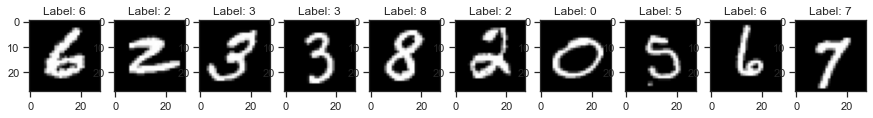

In [81]:
# 2.1 visualize samples from the dataset
def visualize_samples(X, Y, num_samples=10):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    for i in range(num_samples):
        # Randomly select an index
        idx = np.random.randint(X.shape[1])

        # Reshape and display the image
        image = X[:, idx].reshape(28, 28)
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Label: {np.argmax(Y[:, idx])}")

    plt.show()

visualize_samples(X_train, Y_train)


# implementation of activation functions

In [82]:
def tanh(x):
    """
    Implements Hyperbolic tangent activation function.

    Parameters:
    - x : Input array.

    Returns:
    - array_like: An array with the hyperbolic tangent applied element-wise to the input array.
    
    """
    return np.tanh(x)


def relu(x):
    """
    Implements Rectified Linear Unit (ReLU) activation function.

    Parameters:
    - x : Input array.

    Returns:
    - array_like: An array with ReLU applied element-wise to the input array.
    
    """
    return np.maximum(x, 0)


def softmax(x):
    """
    Implements the softmax activation function.

    Parameters:
    - x : Input array.

    Returns:
    - array_like: An array with the softmax applied column-wise to the input array.

    """
    expX = np.exp(x)
    return expX / np.sum(expX, axis=0)


In [83]:
# derivative functions are used in backpropagation

def derivative_tanh(x):
    """
    Implements the derivative of the hyperbolic tangent activation function.

    Parameters:
    - x : Input array.

    Returns:
    - array_like: An array with the derivative of tanh applied element-wise to the input array.

    """
    return (1 - np.power(np.tanh(x), 2))


def derivative_relu(x):
    """
    Implements the derivative of the Rectified Linear Unit (ReLU) activation function.

    Parameters:
    - x : Input array.

    Returns:
    - array_like: An array with the derivative of ReLU applied element-wise to the input array.

    """
    return np.array(x > 0, dtype=np.float32)


# Initialize parameters

In [84]:
# neurons count n_x = i/p layer , n_h = hidden layer, n_y = output layer

def initialize_parameters(n_x, n_h, n_y):
    """
    Initializes the parameters (weights and biases) for a neural network with specified layer dimensions.

    Parameters:
    - n_x (int): Number of neurons in the input layer.
    - n_h (int): Number of neurons in the hidden layer.
    - n_y (int): Number of neurons in the output layer.

    Returns:
    - dict: A dictionary containing the initialized parameters:
            - 'w1' : Weight matrix for the first layer with shape (n_h, n_x).
            - 'b1' : Bias vector for the first layer with shape (n_h, 1).
            - 'w2' : Weight matrix for the second layer with shape (n_y, n_h).
            - 'b2' : Bias vector for the second layer with shape (n_y, 1).

    """
    w1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    
    w2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    parameters = {
        "w1": w1,
        "b1": b1,
        "w2": w2,
        "b2": b2
    }
    
    return parameters


# Forward Propogation

In [85]:
def forward_propagation(x, parameters):
    """
    Implements forward propagation to compute the outputs of each layer in a neural network.

    Parameters:
    - x : Input data with shape (n_x, m), where n_x is the number of features and m is the number of samples.
    - parameters (dict): Dictionary containing the parameters (weights and biases) of the neural network:
                         - 'w1' : Weight matrix for the first layer).
                         - 'b1' : Bias vector for the first layer.
                         - 'w2' : Weight matrix for the second layer.
                         - 'b2' : Bias vector for the second layer.

    Returns:
    - dict: A dictionary containing the intermediate values computed during forward propagation:
            - 'z1' : Output of the first layer before activation function.
            - 'a1' : Output of the first layer after activation function.
            - 'z2' : Output of the second layer before activation function.
            - 'a2' : Output of the second layer after activation function (softmax).

    """
    w1 = parameters['w1']
    b1 = parameters['b1']
    w2 = parameters['w2']
    b2 = parameters['b2']
    
    z1 = np.dot(w1, x) + b1
    a1 = tanh(z1)
    
    z2 = np.dot(w2, a1) + b2
    a2 = softmax(z2)
    
    forward_cache = {
        "z1": z1,
        "a1": a1,
        "z2": z2,
        "a2": a2
    }
    
    return forward_cache

# Cost function

In [86]:
def cost_function(a2, y):
    """
    Implements the cross-entropy cost function for a neural network prediction.

    Parameters:
    - a2 : Predicted probabilities for each class
    - y : True labels

    Returns:
    - float: The cross-entropy cost.

    """
    m = y.shape[1]
    cost = -(1 / m) * np.sum(y * np.log(a2))
    return cost


# Backpropatgation

In [87]:
def backward_prop(x, y, parameters, forward_cache):
    """
    Implements backward propagation function to compute the gradients.

    Parameters:
    - x : Input data 
    - y : True labels 
    - parameters (dict): Dictionary containing the parameters (weights and biases) of the neural network:
                         - 'w1' (array_like): Weight matrix for the first layer.
                         - 'b1' (array_like): Bias vector for the first layer.
                         - 'w2' (array_like): Weight matrix for the second layer.
                         - 'b2' (array_like): Bias vector for the second layer.
    - forward_cache (dict): Dictionary containing the intermediate values computed during forward propagation:
                            - 'a1' : Output of the first layer after activation function.
                            - 'a2' : Output of the second layer after activation function (softmax).

    Returns:
    - dict: A dictionary containing the gradients of the neural network parameters:
            - 'dw1' : Gradient of the weight matrix for the first layer.
            - 'db1' : Gradient of the bias vector for the first layer.
            - 'dw2' : Gradient of the weight matrix for the second layer.
            - 'db2' : Gradient of the bias vector for the second layer.

    """
    w1 = parameters['w1']
    b1 = parameters['b1']
    w2 = parameters['w2']
    b2 = parameters['b2']
    
    a1 = forward_cache['a1']
    a2 = forward_cache['a2']
    
    # m is total number of observations
    
    m = x.shape[1]
    
    dz2 = (a2 - y)
    dw2 = (1 / m) * np.dot(dz2, a1.T)
    db2 = (1 / m) * np.sum(dz2, axis=1, keepdims=True)
    
    # keepims true returns proper shape example (2,1)
    
    dz1 = (1 / m) * np.dot(w2.T, dz2) * derivative_tanh(a1)
    dw1 = (1 / m) * np.dot(dz1, x.T)
    db1 = (1 / m) * np.sum(dz1, axis=1, keepdims=True)
    
    gradients = {
        "dw1": dw1,
        "db1": db1,
        "dw2": dw2,
        "db2": db2
    }
    
    return gradients


# Update Parameters

In [88]:
def update_parameters(parameters, gradients, learning_rate):
    """
    Implements Update the parameters function (weights and biases) of the neural network using gradient descent.

    Parameters:
    - parameters (dict): Dictionary containing the current parameters (weights and biases) of the neural network:
                         - 'w1' : Weight matrix for the first layer
                         - 'b1' : Bias vector for the first layer 
                         - 'w2' : Weight matrix for the second layer 
                         - 'b2' : Bias vector for the second layer 
                         
    - gradients (dict): Dictionary containing the gradients of the parameters computed during backpropagation:
                        - 'dw1' : Gradient of the weight matrix for the first layer
                        - 'db1' : Gradient of the bias vector for the first layer
                        - 'dw2' : Gradient of the weight matrix for the second layer
                        - 'db2' : Gradient of the bias vector for the second layer
                        
    - learning_rate (float): The learning rate used for gradient descent.

    Returns:
    - dict: A dictionary containing the updated parameters (weights and biases) of the neural network.

    """
    w1 = parameters['w1']
    b1 = parameters['b1']
    w2 = parameters['w2']
    b2 = parameters['b2']
    
    dw1 = gradients['dw1']
    db1 = gradients['db1']
    dw2 = gradients['dw2']
    db2 = gradients['db2']
    
    w1 = w1 - learning_rate * dw1
    b1 = b1 - learning_rate * db1
    w2 = w2 - learning_rate * dw2
    b2 = b2 - learning_rate * db2
    
    updated_parameters = {
        "w1": w1,
        "b1": b1,
        "w2": w2,
        "b2": b2
    }
    
    return updated_parameters


# Complete model 

In [89]:
def model(x, y, n_h, learning_rate, iterations):
    """
    method to Train a neural network model using forward and backward propagation.

    Parameters:
    - x : Input data 
    - y : True labels 
    - n_h (int): Number of neurons in the hidden layer.
    - learning_rate (float): The learning rate used for gradient descent.
    - iterations (int): Number of iterations for training the model.

    Returns:
    - tuple: A tuple containing the trained parameters (weights and biases) of the neural network and the list of costs during training.

    """
    n_x = x.shape[0]
    n_y = y.shape[0]
    
    cost_list = []  # Keep track of the cost for every iteration
    
    # Initialize parameters
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Training loop
    for i in range(iterations):
        # Forward propagation
        forward_cache = forward_propagation(x, parameters)
        
        # Compute cost
        cost = cost_function(forward_cache['a2'], y)
        
        # Backward propagation
        gradients = backward_prop(x, y, parameters, forward_cache)
        
        # Update parameters
        parameters = update_parameters(parameters, gradients, learning_rate)
        
        cost_list.append(cost)
        
        if i % (iterations / 10) == 0:
            print("Cost after", i, "iterations is :", cost)
        
    return parameters, cost_list


In [90]:
iterations = 200
n_h = 1000
learning_rate = 0.02
Parameters, Cost_list = model(X_train, Y_train, n_h = n_h, learning_rate = learning_rate, iterations = iterations)

Cost after 0 iterations is : 2.293495710500984
Cost after 20 iterations is : 0.903262303583898
Cost after 40 iterations is : 0.6674413670378219
Cost after 60 iterations is : 0.5699566583839415
Cost after 80 iterations is : 0.514707615657817
Cost after 100 iterations is : 0.47817692623820335
Cost after 120 iterations is : 0.4517132161062983
Cost after 140 iterations is : 0.43135610156052245
Cost after 160 iterations is : 0.4150214300831442
Cost after 180 iterations is : 0.4014999610319371


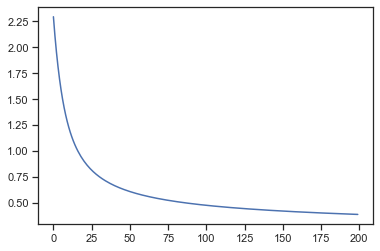

In [91]:
t = np.arange(0, iterations)
plt.plot(t, Cost_list)
plt.show()

In [92]:
def accuracy(inp, labels, parameters):
    """
    method to compute the accuracy of the neural network predictions on a given dataset.

    Parameters:
    - inp : Input data
    - labels : True labels 
    - parameters (dict): Dictionary containing the parameters (weights and biases) of the trained neural network:
                         - 'w1' : Weight matrix for the first layer.
                         - 'b1' : Bias vector for the first layer.
                         - 'w2' : Weight matrix for the second layer.
                         - 'b2' : Bias vector for the second layer.

    Returns:
    - float: The accuracy of the neural network predictions on the given dataset as a percentage.
    
    """
    # Perform forward propagation to obtain predictions
    forward_cache = forward_propagation(inp, parameters)
    a_out = forward_cache['a2']  # Contains probabilities with shape (n_y, m)
    
    # Convert probabilities to predicted labels
    a_out = np.argmax(a_out, 0)  # 0 represents row wise 
    
    # Convert one-hot encoded labels to actual labels
    labels = np.argmax(labels, 0)
    
    # Compute accuracy
    acc = np.mean(a_out == labels) * 100
    
    return acc

In [93]:
print("Accuracy of Train Dataset", accuracy(X_train, Y_train, Parameters), "%")
print("Accuracy of Test Dataset", round(accuracy(X_test, Y_test, Parameters), 2), "%")

Accuracy of Train Dataset 89.55333333333333 %
Accuracy of Test Dataset 90.2 %


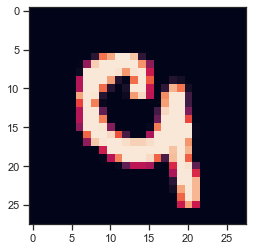

Our model says it is : 9


In [95]:
idx = int(random.randrange(0,X_test.shape[1]))
plt.imshow(X_test[:, idx].reshape((28,28)))
plt.show()

cache = forward_propagation(X_test[:, idx].reshape(X_test[:, idx].shape[0], 1), Parameters)
a_pred = cache['a2']  
a_pred = np.argmax(a_pred, 0)

print("Our model says it is :", a_pred[0])